<a href="https://colab.research.google.com/github/maxs24/GAN_modification/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22__keras_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
 
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization


file = files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle datasets download -d sameepvani/nasa-nearest-earth-objects
!unzip nasa-nearest-earth-objects.zip


Saving kaggle.json to kaggle.json
 76% 5.00M/6.60M [00:00<00:00, 38.5MB/s]
100% 6.60M/6.60M [00:00<00:00, 47.0MB/s]
Archive:  nasa-nearest-earth-objects.zip
  inflating: neo.csv                 
  inflating: neo_v2.csv              


In [ ]:
def new_model(configuration):
  model = tf.keras.Sequential()

  for layer in configuration['layers']:
        model.add(layer)

  loss = configuration['loss']
  optimizator = configuration['optimizator']
  return {'model': model, 'loss': loss, 'optimizator': optimizator}


def generator_loss(fake_output, generator_loss):
  loss = generator_loss(tf.ones_like(fake_output), fake_output)
  return loss


def discriminator_loss(real_output, fake_output, discriminator_loss):
  real_loss = discriminator_loss(tf.ones_like(real_output), real_output)
  fake_loss = discriminator_loss(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


def normalization(data_frame,  column_list):
  data_frame_normal = pd.DataFrame()
  mean_list = []
  std_list = []

  for key, value in column_list.items():
    if value:
      mean_list.append(data_frame[key].mean())
      std_list.append(data_frame[key].std())
      data_frame_normal[key] = (data_frame[key]-mean_list[-1]) / std_list[-1]
    else:
      data_frame_normal[key] = data_frame[key]
  return data_frame_normal, mean_list, std_list


def denormalization(predict, mean_list, std_list):
  new_predict = []
  i = 0
  for index, pr in enumerate(predict):
      if index not in BOOL_INDEX:
        new_predict.append(pr*std_list[i] + mean_list[i])
        i += 1
      else:
        new_predict.append(pr)
  return new_predict


def bool_to_int(data_frame, column_list):
  for key, value in column_list.items():
    if not value:
      data_frame.loc[data_frame[key] == False, key] = 0
      data_frame.loc[data_frame[key] == True, key] = 1

  
def import_csv():
  df = pd.read_csv("neo.csv")
  df = df.drop(columns='orbiting_body')
  df = df.drop(columns='id')
  df = df.drop(columns='name')
  df = df.drop(columns='sentry_object')

  df_false = df.loc[df['hazardous']==False].head(12000)
  df_true = df.loc[df['hazardous']==True]
  return pd.concat([df_true, df_false])


def is_duplicate(pr, tr):
  i = 0
  while i < INPUT_DIMENSION:
    if abs(pr[i] - tr[i]) > tr[i] * PERCENT:
      return False
    i += 1
  return True


def delete_duplicates(predict, train):
  result = []
  for pr in predict:
    is_dupl = False
    for tr in train:
        if is_duplicate(pr, tr):
          is_dupl = True

    if not is_dupl:
      result.append(pr)
  return result

def float_to_bool(predict):
  for pr in predict:
    if pr[-1] > 0.5:
      pr[-1] = True
    else:
      pr[-1] = False

In [ ]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE//4, INPUT_DIMENSION])

  with tf.GradientTape() as gen_tape_1, tf.GradientTape() as disc_tape_1, tf.GradientTape() as gen_tape_2, tf.GradientTape() as disc_tape_2, tf.GradientTape() as gen_tape_3, tf.GradientTape() as disc_tape_3, tf.GradientTape() as gen_tape_4, tf.GradientTape() as disc_tape_4:
    
    generated_samples = []
    for generator in generators:
      generated_samples.append(list())
      for i in range(4):
          generated_samples[-1].append(generator['model'](noise, training=True))
    
    real_output = []
    for discriminator in discriminators:
      real_output.append(discriminator['model'](images, training=True))

    fake_output = []
    for index, discriminator in enumerate(discriminators):
      fake_output.append(list())
      for i in range(4):
        fake_output[-1].append(discriminator['model'](generated_samples[i][index], training=True))

    gen_loss = []
    for index, generator in enumerate(generators):
      gen_loss.append(generator_loss(tf.concat([fake_output[0][index], fake_output[1][index], fake_output[2][index], fake_output[3][index]], axis=0), generator['loss']))

    disc_loss = []
    for index, discriminator in enumerate(discriminators):
      disc_loss.append(discriminator_loss(real_output[index], tf.concat([fake_output[0][index], fake_output[1][index], fake_output[2][index], fake_output[3][index]], axis=0), discriminator['loss']))
    

  gradients_of_generator = []
  gradients_of_generator.append(gen_tape_1.gradient(gen_loss[0], generators[0]['model'].trainable_variables))
  gradients_of_generator.append(gen_tape_2.gradient(gen_loss[1], generators[1]['model'].trainable_variables))
  gradients_of_generator.append(gen_tape_3.gradient(gen_loss[2], generators[2]['model'].trainable_variables))
  gradients_of_generator.append(gen_tape_4.gradient(gen_loss[3], generators[3]['model'].trainable_variables))

  gradients_of_discriminator = []
  gradients_of_discriminator.append(disc_tape_1.gradient(disc_loss[0], discriminators[0]['model'].trainable_variables))
  gradients_of_discriminator.append(disc_tape_2.gradient(disc_loss[1], discriminators[1]['model'].trainable_variables))
  gradients_of_discriminator.append(disc_tape_3.gradient(disc_loss[2], discriminators[2]['model'].trainable_variables))
  gradients_of_discriminator.append(disc_tape_4.gradient(disc_loss[3], discriminators[3]['model'].trainable_variables))


  for index, generator in enumerate(generators):
      generator['optimizator'].apply_gradients(zip(gradients_of_generator[index], generator['model'].trainable_variables))
  
  for index, discriminator in enumerate(discriminators):
    discriminator['optimizator'].apply_gradients(zip(gradients_of_discriminator[index], discriminator['model'].trainable_variables))
  

  return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  history_1 = []
  history_2 = []
  history_3 = []
  history_4 = []

  MAX_PRINT_LABEL = 10
  th = buffer_size // (BATCH_SIZE*MAX_PRINT_LABEL)
  for epoch in range(1, epochs+1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = [0, 0, 0, 0]
    cur_record = 0
    for i in range(batch_count):
      image_batch = tf.convert_to_tensor(dataset[cur_record:cur_record+BATCH_SIZE], tf.float32)
      gen_loss, disc_loss = train_step(image_batch)
      
      for i in range(len(gen_loss_epoch)):
        gen_loss_epoch[i] += K.mean(gen_loss[i])

      if( n % th == 0): print('=', end='')
      n += 1

    history_1 += [gen_loss_epoch[0]/n]
    history_2 += [gen_loss_epoch[1]/n]
    history_3 += [gen_loss_epoch[2]/n]
    history_4 += [gen_loss_epoch[3]/n]

    print(': '+str(history_1[-1]))
    print ('Время эпохи {} составляет {} секунд'.format(epoch + 1, time.time()-start))
  
  return history_1, history_2, history_3, history_4

In [ ]:
BATCH_SIZE = 32
INPUT_DIMENSION = 6
PERCENT = 0.05
EPOCHS = 2
BOOL_INDEX = [5]

In [ ]:
df = import_csv()

columns_dict = {}
for col in df.columns:
  if col == 'hazardous':
    columns_dict[col] = False
  else:
    columns_dict[col] = True

df_normal, mean, std = normalization(df, columns_dict)
bool_to_int(df_normal, columns_dict)

x_train = df_normal.to_numpy()

buffer_size = x_train.shape[0] // BATCH_SIZE * BATCH_SIZE
batch_count = buffer_size // BATCH_SIZE

x_train = x_train[:buffer_size]
np.random.shuffle(x_train)

In [ ]:
list_generator_configurations = [
    {'layers': [Dense(64, activation='relu',input_dim=INPUT_DIMENSION),
                Dense(32, activation='relu'),
                Dense(INPUT_DIMENSION, activation='relu')
                ],
     'optimizator': tf.keras.optimizers.Adamax(1e-4),
     'loss': tf.keras.losses.BinaryCrossentropy()},

    {'layers': [Dense(32, activation='relu',input_dim=INPUT_DIMENSION),
                Dense(8, activation='relu'),
                Dense(INPUT_DIMENSION, activation='sigmoid')
                ],
     'optimizator': tf.keras.optimizers.Adam(1e-4),
     'loss': tf.keras.losses.BinaryCrossentropy()},

    {'layers': [Dense(16, activation='relu',input_dim=INPUT_DIMENSION),
                Dense(8, activation='relu'),
                Dense(INPUT_DIMENSION, activation='softmax')
                ],
     'optimizator': tf.keras.optimizers.Adamax(1e-4),
     'loss': tf.keras.losses.BinaryCrossentropy()},

    {'layers': [Dense(128, activation='relu',input_dim=INPUT_DIMENSION), Dropout(0.5),
                Dense(32, activation='relu'),
                Dense(INPUT_DIMENSION, activation='softmax')
                ],
     'optimizator': tf.keras.optimizers.Adam(1e-4),
     'loss': tf.keras.losses.BinaryCrossentropy()}
]

list_discriminator_configurations = [
    {'layers': [Dense(128, activation='relu',input_dim=INPUT_DIMENSION), Dropout(0.5),
                Dense(64, activation='relu'),
                Dense(1, activation='sigmoid')
                ],
     'optimizator': tf.keras.optimizers.Adamax(1e-4),
     'loss': tf.keras.losses.CategoricalCrossentropy()},

    {'layers': [Dense(64, activation='relu',input_dim=INPUT_DIMENSION),
                Dense(32, activation='relu'),
                Dense(1, activation='softmax')
                ],
     'optimizator': tf.keras.optimizers.Adam(1e-4),
     'loss': tf.keras.losses.CategoricalCrossentropy()},

    {'layers': [Dense(32, activation='relu',input_dim=INPUT_DIMENSION),
                Dense(8, activation='relu'),
                Dense(1, activation='softmax')
                ],
     'optimizator': tf.keras.optimizers.Adamax(1e-4),
     'loss': tf.keras.losses.CategoricalCrossentropy()},

    {'layers': [Dense(64, activation='relu',input_dim=INPUT_DIMENSION),
                Dense(16, activation='relu'),
                Dense(1, activation='sigmoid')
                ],
     'optimizator': tf.keras.optimizers.Adam(1e-4),
     'loss': tf.keras.losses.CategoricalCrossentropy()}
]

generators = []
for config in list_generator_configurations:
  generators.append(new_model(config))

discriminators = []
for config in list_discriminator_configurations:
  discriminators.append(new_model(config))

# запуск процесса обучения
history_1, history_2, history_3, history_4 = train(x_train, EPOCHS)

1/2: ===========: tf.Tensor(0.33541948, shape=(), dtype=float32)
Время эпохи 2 составляет 20.60534930229187 секунд
2/2: ===========: tf.Tensor(0.2955997, shape=(), dtype=float32)
Время эпохи 3 составляет 3.6898176670074463 секунд


In [ ]:
res = []
res_1 = []
for m in x_train[0:5]:
  res.append(denormalization(m, mean, std))
  res_1.append(denormalization(m, mean, std))

res_dupl = delete_duplicates(res, res_1)
for r in res_dupl:
  print(r)

In [ ]:
noise = tf.random.normal([100, INPUT_DIMENSION])
mas_1 = generators[1]['model'].predict(noise)
res = []
for m in mas_1:
  res.append(denormalization(m, mean, std))
float_to_bool(res)
res_dupl = delete_duplicates(res, df.to_numpy())
for r in res_dupl:
  print(r)

4/4 [==============================] - 0s 4ms/step
[0.31766048259457996, 0.9376356597170192, 73907.26759212281, 61075887.95186061, 24.077853483346566, True]
[0.24034838168725803, 0.7939512743271555, 68599.10081596195, 60961805.15268414, 23.541192573746976, False]
[0.23843964202704285, 0.7965316437091663, 68906.98688729202, 60949055.30964807, 23.52908150314287, False]
[0.27606069657693894, 0.9138616253982854, 74008.99552294845, 60888755.86342771, 23.88299846524292, True]
[0.29972794432944866, 0.8617052954604234, 71360.00786070534, 58597997.07638454, 23.727386974783936, True]
[0.2962881588024221, 0.8923080202084352, 73079.73812283459, 59022677.4442945, 23.78284503395978, True]
[0.2814194282064213, 0.8963879897539109, 73242.33488482691, 60197757.7703968, 23.81605992236393, True]
[0.3017348658669815, 0.8908950316114493, 72748.24089002534, 59231727.525150955, 23.811404644617873, True]
[0.3219023330102598, 0.8335843003412596, 69437.4345751647, 57271281.03367104, 23.696248070185675, True]
[0.

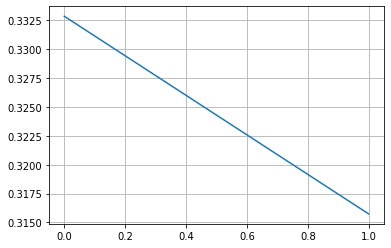

In [ ]:
plt.plot(history_1)
plt.grid(True)

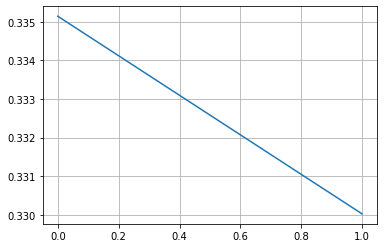

In [ ]:
plt.plot(history_2)
plt.grid(True)

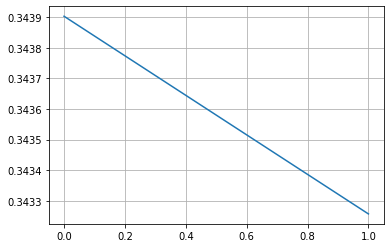

In [ ]:
plt.plot(history_3)
plt.grid(True)

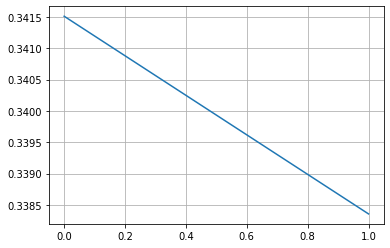

In [ ]:
plt.plot(history_4)
plt.grid(True)

In [ ]:
history_1

[<tf.Tensor: shape=(), dtype=float32, numpy=0.33286256>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3157376>]

In [ ]:
history_2

[<tf.Tensor: shape=(), dtype=float32, numpy=0.33514166>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33002526>]

In [ ]:
history_3

[<tf.Tensor: shape=(), dtype=float32, numpy=0.34390354>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.34325677>]

In [ ]:
history_4

[<tf.Tensor: shape=(), dtype=float32, numpy=0.3415135>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33835426>]